In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import numpy as np
from tqdm.auto import tqdm

import whynot as wn

from whynot.simulators.lending.simulator import INV_CDFS, GROUP_SIZE_RATIO

For illustrative purposes, we show how to construct the "credit bureau" intervention in WhyNot.
The user writes a handful of small functions, each determining a different aspect of the causal experiment.

In [3]:
def sample_initial_states(rng):
    """Sample initial states according to FICO data on group membership.
    Each initial state corresponds to an agent.
    """
    group = int(rng.uniform() < GROUP_SIZE_RATIO[1])
    # Compute score via inverse CDF trick
    score = INV_CDFS[group](rng.uniform())
    return wn.lending.State(group=group, score=score)

In [4]:
@wn.parameter(
    name="threshold_g0", default=650, description="Lending threshold for group 0")
@wn.parameter(
    name="threshold_g1", default=650, description="Lending threshold for group 1")
def construct_config(threshold_g0, threshold_g1):
    """Return the experimental config for runs without intervention"""
    # Each rollout is a single timestep and only the lending thresholds are varied.
    return wn.lending.Config(
        start_time=0, end_time=1, threshold_g0=threshold_g0, threshold_g1=threshold_g1
    )


In [5]:
def extract_outcomes(run):
    """Outcome is the score change Delta and the institutions profit after 1 step."""
    return [run.states[1].score - run.states[0].score, run.states[1].profits]

In [6]:
def creditscore_threshold(score):
    """Alternate credit bureau scoring policy."""
    return max(score, 600)

In [7]:
# Construct the experiment
CreditBureauExperiment = wn.DynamicsExperiment(
    name="CreditBureauExperiment",
    description="Intervention on the credit scoring mechanism.",
    simulator=wn.lending,
    simulator_config=construct_config,
    # Change the credit scoring mechanism on the first step.
    intervention=wn.lending.Intervention(credit_scorer=creditscore_threshold, time=0),
    state_sampler=sample_initial_states,
    # All units are treated
    propensity_scorer=1.0,
    outcome_extractor=extract_outcomes,
    # Only covariate is group membership
    covariate_builder=lambda run: run.initial_state.group,
)

Compute average score changes for the minority, as well as institutional profits, as the minority threshold
varies and the majority threshold is fixed.

In [22]:
minority_thresholds = list(range(300, 800, 10))

average_min_score_changes = []
average_inst_profits = []
for tau_0 in tqdm(minority_thresholds):
    # Run the experiment to generate the dataset
    dataset = CreditBureauExperiment.run(threshold_g0=tau_0, num_samples=1000, parallelize=True)    
    
    # Only consider score changes for the minority group
    minority_locs = dataset.covariates[:, 0] == 0
    minority_treated_locs = minority_locs & (dataset.treatments == 1)

    score_changes = dataset.outcomes[:, 0]
    min_changes = score_changes[minority_treated_locs]
    average_min_score_changes.append(np.mean(min_changes))
        
    # Report profits over the entire group
    ind_profits = dataset.outcomes[:, 1][dataset.treatments == 1]
    average_inst_profits.append(np.mean(ind_profits))

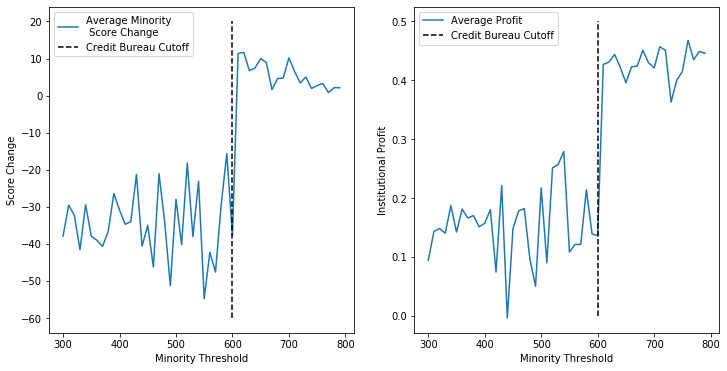

In [41]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(minority_thresholds, average_min_score_changes, label="Average Minority\n Score Change")
axs[0].plot([600] * 20, np.linspace(-60, 20, 20), label="Credit Bureau Cutoff", linestyle="--", color="black")
axs[0].legend()
axs[0].set_xlabel("Minority Threshold")
axs[0].set_ylabel("Score Change")
axs[1].plot(minority_thresholds, average_inst_profits, label="Average Profit")
axs[1].plot([600] * 20, np.linspace(0, 0.5, 20), label="Credit Bureau Cutoff", linestyle="--", color="black")
axs[1].set_xlabel("Minority Threshold")
axs[1].set_ylabel("Institutional Profit")
axs[1].legend();